Predicción de gastos médicos usando regresión lineal
===

Descripción del problema
---

Una compañía de seguros desea pronósticar los gastos médicos de la población asegurada con el fin de recolectar un valor superior en ingresos, tal que le permita obtener utilidades. Los costos son difíciles de pronósticar ya que las condiciones más costosas son más raras y parecen aleatorias; y que ciertas condiciones son más probables para ciertos segmentos de la población (infarto en personas obesas y cáncer en fumadores).

El objetivo es usar una base de datos con 1338 registros de gastos médicos hipotéticos para pacientes de EU con el fin de estimar los costos para determinados segmentos de la población. La información registrada es la siguiente:

* Age: entero hasta 64.

* Sex: male, female.

* bmi: Body mass index.

* children: entero indicando la cantidad de hijos/dependientes cubiertos por el plan de salud.

* smoker: yes, no.

* region: northest, southeast, southwest, northwest.

* charges: costos.


Lectura de datos
--

In [1]:
import pandas as pd

#
# Lectura del archivo y verificación
#
df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/insurance.csv",
    sep=",",
    thousands=None,
    decimal=".",
)

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Especificación del modelo
---

In [2]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder

columnTransformer = ColumnTransformer(
    transformers=[
        (
            "ohe",
            OneHotEncoder(drop="if_binary"),
            make_column_selector(dtype_include=object),
        ),
    ],
    remainder="passthrough",
)

In [3]:
from sklearn.feature_selection import SelectKBest, f_regression

selectKBest = SelectKBest(score_func=f_regression)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    [
        ("columnTransformer", columnTransformer),
        ("selectKBest", selectKBest),
        ("linearRegression", LinearRegression()),
    ]
)

In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "selectKBest__k": [1, 2, 3, 4, 5, 6, 7, 8],
}

gridSearchCV = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    refit=True,
)

Estimación del modelo
---

In [6]:
X = df.copy().drop("charges", axis="columns")
y = df.copy().pop("charges")

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [8]:
gridSearchCV.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columnTransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f535ac670d0>)])),
                                       ('selectKBest',
                                        SelectKBest(score_func=<function f_regression at 0x7f532c161ca0>)),
                                       ('linearRegression',
                                        LinearRegression())]),
             param_grid={'selectKBest__k': [1, 2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

In [9]:
gridSearchCV.best_params_

{'selectKBest__k': 4}

In [10]:
y_train_pred = gridSearchCV.predict(X_train)
y_test_pred = gridSearchCV.predict(X_test)

Evaluación de error
---

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

print(f"Mean squared error: {mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Variance score: {r2_score(y_train, y_train_pred):.2f}")

Mean squared error: 37396262.08
Variance score: 0.74


In [12]:
print(f"Mean squared error: {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Variance score: {r2_score(y_test, y_test_pred):.2f}")

Mean squared error: 35299792.10
Variance score: 0.76


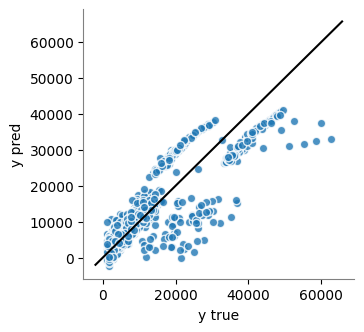

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_forecasts(y_true, y_pred):
    plt.figure(figsize=(3.5, 3.5))
    plt.scatter(y_true, y_pred, color="tab:blue", alpha=0.8, edgecolors="white")
    plt.xlabel("y true")
    plt.ylabel("y pred")
    x_ = np.linspace(*plt.gca().get_xlim())
    plt.gca().plot(x_, x_, "k-")
    plt.gca().spines["left"].set_color("gray")
    plt.gca().spines["bottom"].set_color("gray")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.plot()
    
plot_forecasts(y_train, y_train_pred)

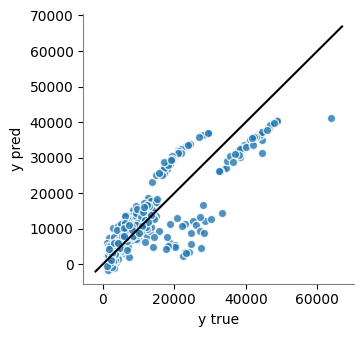

In [14]:
plot_forecasts(y_test, y_test_pred)